In [1]:
!pip install torchtext==0.6.0 # need to run and restart runtime for TabularDataset, Field and LabelField imports

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.8 MB/s 
     |████████████████████████████████| 1.2 MB 57.6 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0


In [2]:
### LIBRARY IMPORTS ###
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchtext
#import torchtext.data as data
from torchtext.data import get_tokenizer, TabularDataset, Field, LabelField
import torchvision.datasets as datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import spacy   # may be unused not sure currently
import nltk
import random

#import torchtext.data as data
#from spacy.en import English

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
!pip install spacey

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 528 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [7]:
data = pd.read_csv("Data.csv") # must upload data csv to run
data[["Tweet", "ratio"]]

,Tweet,ratio
0,Use a emoji to describe Rafa Nadal 👇,0.8459
1,@seahawksfan2314 @SportsCenter not a sport say...,0.0160
2,Just played tennis. Probably shouldn’t have wo...,0.0878
3,THE BOYZ WORLD TOUR : THE B-ZONE IN JAKARTA🌐\n...,0.0975
4,What are the toughest sports out there? Boxing...,0.3592
...,...,...
95,late night tennis! cheers @Janina for the phot...,0.1548
96,"time for tennis, me vs luke. who do you think ...",0.8887
97,"had a nice tennis session, hot and sweaty ; ) ...",0.2110
98,Playin some tennis with my cousins ✊,0.0616


In [8]:
### https://stackoverflow.com/questions/33098040/how-to-use-word-tokenize-in-data-frame ###
# data['tokenized_tweets'] = data.apply(lambda row: nltk.word_tokenize(row['Tweet']), axis=1) # tokenize tweets
data_reduced = data[["Tweet", "ratio"]]

In [9]:
data_reduced.tail()

,Tweet,ratio
95,late night tennis! cheers @Janina for the phot...,0.1548
96,"time for tennis, me vs luke. who do you think ...",0.8887
97,"had a nice tennis session, hot and sweaty ; ) ...",0.2110
98,Playin some tennis with my cousins ✊,0.0616
99,Good early morning tennis match with the baes 🎾,0.2962


In [10]:
# convert to tabular dataset
data_reduced.to_csv("tokenized_data.csv", index=None)
tokenised_data = Field(tokenize="spacy", tokenizer_language="en_core_web_sm")
# https://github.com/pytorch/text/issues/78
labels = LabelField(dtype = torch.float, use_vocab=False, preprocessing=float)#, postprocessing=torchtext.data.Pipeline(lambda x: float(x))) # converting string ratios to doubles and not using a vocab for target labels
dataset = TabularDataset(path="tokenized_data.csv", format="CSV", fields=[("tweet", tokenised_data),("ratio", labels)],skip_header=True)
vars(dataset[0])

{'ratio': 0.8459,
 'tweet': ['Use', 'a', 'emoji', 'to', 'describe', 'Rafa', 'Nadal', '👇']}

In [11]:
train_set, val_set, test_set = dataset.split(split_ratio=[0.7, 0.15, 0.15],random_state=random.seed(0))  

In [12]:
tokenised_data.build_vocab(train_set, max_size=20000) # dictionary stores a maximum of 20000 words as to get the jist of the tweets while saving space.
labels.build_vocab(train_set) 
print(len(tokenised_data.vocab))
tokenised_data.vocab.freqs.most_common(20)
tokenised_data.vocab.itos[21]


998


'you'

In [13]:
print(len(train_set), len(val_set), len(test_set))

70 15 15


In [14]:
sanity_set = dataset # for now, later when we have actual dataset, this will need to be removed to only be a subset of roughly 100 tweets from the dataset

In [15]:
train_loader  = torchtext.data.BucketIterator( train_set, batch_size=10, device = device, shuffle=True, sort_key = len, sort_within_batch=False)
val_loader    = torchtext.data.BucketIterator(   val_set, batch_size=10, device = device, shuffle=True, sort_key = len, sort_within_batch=False)
test_loader   = torchtext.data.BucketIterator(  test_set, batch_size=10, device = device, shuffle=True, sort_key = len, sort_within_batch=False)
sanity_loader = torchtext.data.BucketIterator(sanity_set, batch_size=10, device = device, shuffle=True, sort_key = len, sort_within_batch=False) # lambda x: len(x.tokenized_tweets)
sanity_set

In [16]:
#for data in sanity_loader:
#  break
for i, data in enumerate(sanity_loader, 0):
  text, label = data
  print(label) 
  print(text)      # each column represents 1 tweet, each word coded to one integer. 1s represent sentence padding, each batch has different sentence lengths
  
  break

tensor([0.0063, 0.0625, 0.1995, 0.5540, 0.0610, 1.5381, 0.1336, 0.1899, 0.0330,
        0.1757], device='cuda:0')
tensor([[400, 378, 353,   7, 102,  19,   7, 110, 397, 406],
        [ 57,  58,  21, 148,  85, 249,  62, 307, 114,  24],
        [209, 903,  89,  43,  29,   5, 260, 383, 685,  17],
        [ 79, 196, 310, 542,  91,  51, 890, 111,  11, 811],
        [ 31,  32,  49,   6,  86,  68,   6, 616,   4, 660],
        [253, 223, 501, 533,   4,   5, 112, 851,  56, 950],
        [263,   6,   4,  32,   5,  93,  31, 761,   7,  14],
        [ 21, 139, 249, 260,   7, 860, 168, 696,  81,  17],
        [655,   3,  51, 205, 100,   6, 123, 531,   6,  45],
        [254,   4,  68, 852, 553,  81, 621, 638, 854,   4],
        [  3,   9,  87,   5, 519, 944,   2, 670, 884,  45],
        [  4, 747,  26, 134,  11,   5,  12,   5,  83,   6],
        [ 64,  58, 447, 834, 288, 186, 105, 697,   1, 539],
        [  9,   6, 246, 217, 895,  31, 885,   5,   1, 150],
        [ 60, 611, 931,  44, 242,  53, 853,   

In [35]:
from torch.nn.modules import dropout
class RatioNet(nn.Module):
  def __init__(self, input_size, batch_size, device, hidden_size=50, embedding_size=20, lstm_input_size=100, num_layers = 2, dropout=0.5):
    super(RatioNet, self).__init__()

    self.name = "RatioNet"
    self.device =device
    self.bs = batch_size
    self.lstmis = lstm_input_size
    self.hs = hidden_size
    self.nl = num_layers

    self.embedding = nn.Embedding(input_size, embedding_size)  # sequence size (padded tweet length), batch_size, embedding size (ie vector representation of integer words)

    self.conv1 = nn.Conv1d(embedding_size, 200, 3)
    o = (64 - 3)//1 + 1         # conv1 output size
    #o = (o - 2)//2 + 1                      # maxpool output size
    #print(o)

    self.conv2 = nn.Conv1d(200, 250, 3)
    o = (o - 3)//1 + 1                      # conv2 output size
    #o = (o - 2)//2 + 1                      # maxpool output size
    #print(o)

    self.conv3 = nn.Conv1d(250, self.lstmis, 3)
    o = (o - 3)//1 + 1                      # conv3 output size
    #print(o)
    self.maxpool = nn.MaxPool1d(2, 2)
    lstm_input_size = (o - 2)//2 + 1        # maxpool output size
    #print(lstm_input_size, "word reduction")

    self.stacked_LSTM = nn.LSTM(input_size = self.lstmis, hidden_size = self.hs, num_layers = self.nl, batch_first=True, dropout=dropout, bidirectional=True) # batch_first==True >>> (batch, seq, features) , batch_first==False (seq, batch, feature)
    
    self.output_layer = nn.Linear(self.hs * 2, 1)

  def forward(self, x):
    # convert integer coded tweets to embeddings
    x = self.embedding(x)
    x = x.permute(1, 2, 0)   # convert to (batch_size, embedding dimension, number of words) order to feed into conv layers (embedding dimension == # channels)
    
    #print(x.size(), "permute")
    x = (F.relu(self.conv1(x)))
    x = (F.relu(self.conv2(x)))
    x = self.maxpool(F.relu(self.conv3(x)))
    #print(x.size())

    x = x.permute(0, 2, 1) # convert to (batch_size, number of words, embedding dimension) order to feed into stacked lstm layer (batch_first set to True) 

    h_0 = torch.ones(self.nl * 2, self.bs, self.hs).to(self.device)
    c_0 = torch.ones(self.nl * 2, self.bs, self.hs).to(self.device)
    x, (h_n, c_n) = self.stacked_LSTM(x, (h_0, c_0))  # output, hidden state, cell state
    # if you visualize the lstm you can see that x[:,-1,:] (output from the final word) is the same as the output of the second hidden layer output (only for non-bidirectional LSTMs)
    # print(h_n[-1]==x[:,-1,:])
    #print(x.size())
    #print(h_n.size())

    # passing lstm final output into output layer for ratio prediction
    #out = F.relu(self.output_layer(h_n[-1])) # output should be above 0 but unbounded above pass in final hidden layer
    out = F.relu(self.output_layer(x[:,-1,:]))
    
    return out

In [18]:
from torch.nn.modules import dropout
class RatioNet2(nn.Module):
  def __init__(self, input_size, batch_size, device, hidden_size=50, embedding_size=20, lstm_input_size=100, num_layers = 2, dropout=0.5):
    super(RatioNet2, self).__init__()

    self.name = "RatioNet2"
    self.device =device
    self.bs = batch_size
    self.lstmis = lstm_input_size
    self.hs = hidden_size
    self.nl = num_layers

    self.embedding = nn.Embedding(input_size, embedding_size)  # sequence size (padded tweet length), batch_size, embedding size (ie vector representation of integer words)

    self.conv1 = nn.Conv1d(embedding_size, 200, 3)
    o = (64 - 3)//1 + 1         # conv1 output size
    #o = (o - 2)//2 + 1                      # maxpool output size
    #print(o)

    self.conv2 = nn.Conv1d(200, self.lstmis, 3)
    o = (o - 3)//1 + 1                      # conv2 output size
    self.maxpool = nn.MaxPool1d(2, 2)
    lstm_input_size = (o - 2)//2 + 1        # maxpool output size
    #print(lstm_input_size, "word reduction")

    self.stacked_LSTM = nn.LSTM(input_size = self.lstmis, hidden_size = self.hs, num_layers = self.nl, batch_first=True, dropout=dropout, bidirectional=True) # batch_first==True >>> (batch, seq, features) , batch_first==False (seq, batch, feature)
    
    self.output_layer = nn.Linear(self.hs * 2, 1)

  def forward(self, x):
    # convert integer coded tweets to embeddings
    x = self.embedding(x)
    x = x.permute(1, 2, 0)   # convert to (batch_size, embedding dimension, number of words) order to feed into conv layers (embedding dimension == # channels)
    
    #print(x.size(), "permute")
    x = (F.relu(self.conv1(x)))
    x = self.maxpool(F.relu(self.conv2(x)))
    #print(x.size())

    x = x.permute(0, 2, 1) # convert to (batch_size, number of words, embedding dimension) order to feed into stacked lstm layer (batch_first set to True) 

    h_0 = torch.ones(self.nl * 2, self.bs, self.hs).to(self.device)
    c_0 = torch.ones(self.nl * 2, self.bs, self.hs).to(self.device)
    x, (h_n, c_n) = self.stacked_LSTM(x, (h_0, c_0))  # output, hidden state, cell state
    # if you visualize the lstm you can see that x[:,-1,:] (output from the final word) is the same as the output of the second hidden layer output (only for non-bidirectional LSTMs)
    # print(h_n[-1]==x[:,-1,:])
    #print(x.size())
    #print(h_n.size())
    #print(self.stacked_LSTM.all_weights)
    # passing lstm final output into output layer for ratio prediction
    #out = F.relu(self.output_layer(h_n[-1])) # output should be above 0 but unbounded above pass in final hidden layer
    out = F.relu(self.output_layer(x[:,-1,:]))    
    return out

In [19]:
class no_conv_RatioNet(nn.Module):
  def __init__(self, input_size, batch_size, device, hidden_size=50, embedding_size=20, lstm_input_size=100, num_layers = 2, dropout=0.5):
    super(no_conv_RatioNet, self).__init__()

    self.name = "no_conv_RatioNet"
    self.device =device
    self.bs = batch_size
    self.lstmis = lstm_input_size
    self.hs = hidden_size
    self.nl = num_layers

    self.embedding = nn.Embedding(input_size, embedding_size)  # sequence size (padded tweet length), batch_size, embedding size (ie vector representation of integer words)

    self.stacked_LSTM = nn.LSTM(input_size = self.lstmis, hidden_size = self.hs, num_layers = self.nl, batch_first=True, dropout=dropout, bidirectional=True) # batch_first==True >>> (batch, seq, features) , batch_first==False (seq, batch, feature)
    
    self.output_layer = nn.Linear(self.hs * 2, 1)

  def forward(self, x):
    # convert integer coded tweets to embeddings
    x = self.embedding(x)
    x = x.permute(1, 0, 2)   # convert to (batch_size, number of words, embedding dimension) order to feed into stacked lstm layer (batch_first set to True)    

    h_0 = torch.ones(self.nl * 2, self.bs, self.hs).to(self.device)
    c_0 = torch.ones(self.nl * 2, self.bs, self.hs).to(self.device)
    x, (h_n, c_n) = self.stacked_LSTM(x, (h_0, c_0))  # output, hidden state, cell state
    # if you visualize the lstm you can see that x[:,-1,:] (output from the final word) is the same as the output of the second hidden layer output (only for non-bidirectional LSTMs)
    # print(h_n[-1]==x[:,-1,:])
    #print(x.size())
    #print(h_n.size())
    
    # passing lstm final output into output layer for ratio prediction
    #out = F.relu(self.output_layer(h_n[-1])) # output should be above 0 but unbounded above pass in final hidden layer
    out = F.relu(self.output_layer(x[:,-1,:]))
    
    return out

In [20]:
from torch.nn.modules import dropout
class no_lstm_RatioNet(nn.Module):
  def __init__(self, input_size, batch_size, device, hidden_size=50, embedding_size=20, lstm_input_size=100, num_layers = 2, dropout=0.5):
    super(no_lstm_RatioNet, self).__init__()

    self.name = "no_lstm_RatioNet"
    self.device =device
    self.bs = batch_size
    self.lstmis = lstm_input_size
    self.hs = hidden_size
    self.nl = num_layers

    self.embedding = nn.Embedding(input_size, embedding_size)  # sequence size (padded tweet length), batch_size, embedding size (ie vector representation of integer words)

    self.conv1 = nn.Conv1d(embedding_size, 200, 3)
    o = (64 - 3)//1 + 1         # conv1 output size
    #o = (o - 2)//2 + 1                      # maxpool output size
    #print(o)

    self.conv2 = nn.Conv1d(200, 250, 3)
    o = (o - 3)//1 + 1                      # conv2 output size
    #o = (o - 2)//2 + 1                      # maxpool output size
    #print(o)

    self.conv3 = nn.Conv1d(250, 300, 3)
    o = (o - 3)//1 + 1                      # conv3 output size
    #print(o)
    self.maxpool = nn.MaxPool1d(2, 2)
    fc_input_size = (o - 2)//2 + 1        # maxpool output size
    #print(lstm_input_size, "word reduction")
    
    self.output_layer = nn.Linear(300, 1)

  def forward(self, x):
    # convert integer coded tweets to embeddings
    x = self.embedding(x)
    x = x.permute(1, 2, 0)   # convert to (batch_size, embedding dimension, number of words) order to feed into conv layers (embedding dimension == # channels)
    
    #print(x.size(), "permute")
    x = (F.relu(self.conv1(x)))
    x = (F.relu(self.conv2(x)))
    x = self.maxpool(F.relu(self.conv3(x)))
    x, _ = x.max(dim=-1)
    out = F.relu(self.output_layer(x))    
    return out

In [21]:
print(text[0].size())
net = RatioNet(input_size=len(tokenised_data.vocab), batch_size=10, device=device, embedding_size=200, hidden_size=200, lstm_input_size=300).to(device)
out = net(text)
#len(tokenised_data.vocab)
print(out, "out") # testing forward pass

torch.Size([10])
tensor([[0.1378],
        [0.1534],
        [0.1606],
        [0.1463],
        [0.1162],
        [0.1456],
        [0.1305],
        [0.1630],
        [0.1253],
        [0.1927]], device='cuda:0', grad_fn=<ReluBackward0>) out


In [22]:
def plot_training_curve(path='', data=[-1,-1,-1,-1]): # from lab 2 with some small additions
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    # If path not given for loading data, read from data input
    # this option was added as sometimes the training would not save the error 
    # and loss as csvs, and rather than retraining the set for hours, I thought 
    # it would be quicker to get the loss and error from the console prints and 
    # place them into arrays.
    if path!='':
      #train_err = np.loadtxt("{}_train_err.csv".format(path))
      #val_err = np.loadtxt("{}_val_err.csv".format(path))
      train_loss = np.loadtxt("{}_train_loss.csv".format(path))
      val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    else:
      #train_err, val_err, 
      train_loss, val_loss = data
    #plt.title("Train vs Validation Error")
    n = len(train_loss) # number of epochs
    #plt.plot(range(1,n+1), train_err, label="Train")
    #plt.plot(range(1,n+1), val_err, label="Validation")
    #plt.xlabel("Epoch")
    #plt.ylabel("Error")
    #plt.legend(loc='best')
    #plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    #plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [38]:
def train_net(net,
              data_loaders,
              epochs=5,
              learning_rate=0.001,
              batch_size=10,
              hidden_size=100,
              embedding_size=20,
              lstm_input_size=100,
              lstm_layers=2,
              dropout=0.5,
              momentum=0.9,
              sanity_check=False,
              device="cpu",
              weight_decay = 1e-5,
              adam=False
              ):
  net.train()
  torch.manual_seed(0)
  net = net.to(device)

  criterion = nn.MSELoss()

  if adam:
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

  # initialize error and loss statistic numpy arrays
  train_err = np.zeros(epochs)
  train_loss= np.zeros(epochs)
  val_err   = np.zeros(epochs)
  val_loss  = np.zeros(epochs)

  start_time = time.time()

  if sanity_check:
    train_load = data_loaders
  else:
    train_load, val_load, test_load = data_loaders
  

  for epoch in range(epochs):
    train_epoch_err = 0
    train_epoch_loss = 0
    val_epoch_err = 0
    val_Epoch_loss = 0
    for i, data in enumerate(train_load,0):
      tweet,ratio = data
      tweet = tweet.to(device)
      ratio = ratio.to(device)

      optimizer.zero_grad()

      out = net(tweet)

      loss = criterion(out, ratio)
      #loss.register_hook(lambda grad: print(grad))
      loss.backward()
      #print(net.conv1.weight.grad)
      optimizer.step()
      train_epoch_loss += loss.item()
    train_loss[epoch] = train_epoch_loss/(i+1)
    print(f"Epoch: {epoch}, Train Loss: {train_loss[epoch]}, Validation Loss: [not yet available], prediction: {out[-1][-1]}, true ratio: {ratio[-1]}")
    model_path = "//content//model_{0}_bs{1}_lr{2}_epoch{3}".format(net.name,
                                                                    batch_size,
                                                                    learning_rate,
                                                                    epoch)
    # save the parameters of the net every n epochs.
    n=5
    if epoch % n == 0:
      torch.save(net.state_dict(), model_path)
  
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
  pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
  print(pytorch_total_params)


In [24]:
def path(name, batch_size, learning_rate, epoch):
  model_path = "//content//model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                                  batch_size,
                                                                  learning_rate,
                                                                  epoch)
  return model_path

In [39]:
#ratio_net = RatioNet(input_size=len(tokenised_data.vocab), batch_size=10)
ratio_net = RatioNet(input_size=len(tokenised_data.vocab), batch_size=10, device=device, embedding_size=200, hidden_size=200, lstm_input_size=300)

train_net(ratio_net, sanity_loader, device=device, sanity_check=True, epochs=500 , learning_rate=0.001, adam=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, Train Loss: 0.24107037521898747, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.03420000150799751
Epoch: 1, Train Loss: 0.1869876306504011, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.23800000548362732
Epoch: 2, Train Loss: 0.1869876359589398, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.05739999935030937
Epoch: 3, Train Loss: 0.18698763884603978, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.45320001244544983
Epoch: 4, Train Loss: 0.18698763847351074, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.16580000519752502
Epoch: 5, Train Loss: 0.18698763698339463, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.35920000076293945
Epoch: 6, Train Loss: 0.18698763363063337, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.17569999396800995
Epoch: 7, Train Loss: 0.18698763940483332, Validation Loss: [not yet available], prediction:

//content//model_RatioNet_bs10_lr0.001_epoch499


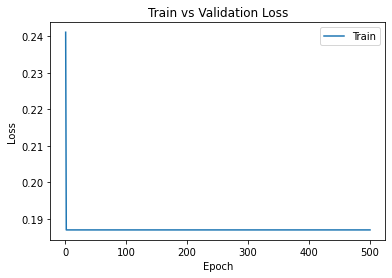

In [40]:
model_path = path(ratio_net.name, 10, 0.001, 499)

#model_path = "model_RatioNet_bs10_lr0.001_epoch495"
print(model_path)
plot_training_curve(model_path)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, Train Loss: 0.23004467319697142, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.21119999885559082
Epoch: 1, Train Loss: 0.18698763214051722, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.21539999544620514
Epoch: 2, Train Loss: 0.18698763400316237, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.06430000066757202
Epoch: 3, Train Loss: 0.1869876366108656, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.08780000358819962
Epoch: 4, Train Loss: 0.18698763130232693, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.016899999231100082
Epoch: 5, Train Loss: 0.186987629160285, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.057500001043081284
Epoch: 6, Train Loss: 0.18698763272259383, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.061000000685453415
Epoch: 7, Train Loss: 0.18698763884603978, Validation Loss: [not yet available], predictio

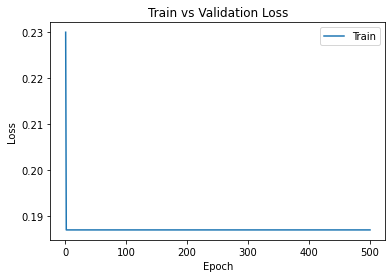

In [41]:
#ratio_net = RatioNet(input_size=len(tokenised_data.vocab), batch_size=10)
ratio_net = RatioNet(input_size=len(tokenised_data.vocab), batch_size=10, device=device, embedding_size=200,num_layers=4, hidden_size=200, lstm_input_size=500)

train_net(ratio_net, sanity_loader, device=device, sanity_check=True, epochs=500 , learning_rate=0.001, adam=True)

model_path = path(ratio_net.name, 10, 0.001, 499)

print(model_path)
plot_training_curve(model_path)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, Train Loss: 19.93190265931189, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.21119999885559082
Epoch: 1, Train Loss: 0.18698763530701398, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.09749999642372131
Epoch: 2, Train Loss: 0.18698764517903327, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.013299999758601189
Epoch: 3, Train Loss: 0.18698763232678176, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.026200000196695328
Epoch: 4, Train Loss: 0.18698763027787207, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.07270000129938126
Epoch: 5, Train Loss: 0.18698763865977525, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.28529998660087585
Epoch: 6, Train Loss: 0.18698764275759458, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.057500001043081284
Epoch: 7, Train Loss: 0.18698763232678176, Validation Loss: [not yet available], predicti

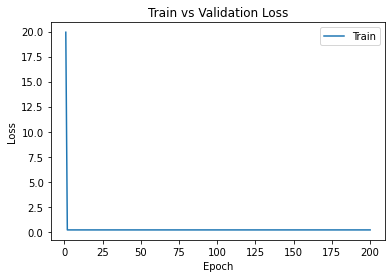

In [42]:
#ratio_net = RatioNet(input_size=len(tokenised_data.vocab), batch_size=10)
ratio_net = RatioNet(input_size=len(tokenised_data.vocab), batch_size=10, device=device, embedding_size=50,num_layers=1, hidden_size=50, lstm_input_size=500)

train_net(ratio_net, sanity_loader, device=device, sanity_check=True, epochs=200 , learning_rate=10, adam=False)

model_path = path(ratio_net.name, 10, 10, 199)

print(model_path)
plot_training_curve(model_path)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, Train Loss: 0.15203523626551033, Validation Loss: [not yet available], prediction: 0.33548691868782043, true ratio: 0.006300000008195639
Epoch: 1, Train Loss: 0.12839226890355349, Validation Loss: [not yet available], prediction: 0.3302033245563507, true ratio: 0.04399999976158142
Epoch: 2, Train Loss: 0.14084033537656068, Validation Loss: [not yet available], prediction: 0.22666576504707336, true ratio: 0.28529998660087585
Epoch: 3, Train Loss: 0.14029381135478616, Validation Loss: [not yet available], prediction: 0.22291621565818787, true ratio: 0.07270000129938126
Epoch: 4, Train Loss: 0.1854032076895237, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.14409999549388885
Epoch: 5, Train Loss: 0.18698764145374297, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.28519999980926514
Epoch: 6, Train Loss: 0.186987629160285, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.6384999752044678
Epoch: 7, Train Loss: 0.186987

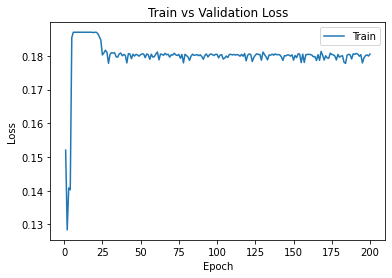

In [57]:
#ratio_net = RatioNet(input_size=len(tokenised_data.vocab), batch_size=10)
ratio_net = no_conv_RatioNet(input_size=len(tokenised_data.vocab), batch_size=10, device=device, embedding_size=50,num_layers=1, hidden_size=50, lstm_input_size=50)

train_net(ratio_net, sanity_loader, device=device, sanity_check=True, epochs=200 , learning_rate=0.01, adam=False)

model_path = path(ratio_net.name, 10, 0.01, 199)

print(model_path)
plot_training_curve(model_path)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, Train Loss: 0.13702635653316975, Validation Loss: [not yet available], prediction: 0.2347220778465271, true ratio: 0.017100000753998756
Epoch: 1, Train Loss: 0.1819350441917777, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.05739999935030937
Epoch: 2, Train Loss: 0.18698764517903327, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.0737999975681305
Epoch: 3, Train Loss: 0.1869876401498914, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.888700008392334
Epoch: 4, Train Loss: 0.18698764443397523, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.21539999544620514
Epoch: 5, Train Loss: 0.18698764108121396, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.032999999821186066
Epoch: 6, Train Loss: 0.18698764070868493, Validation Loss: [not yet available], prediction: 0.0, true ratio: 0.08070000261068344
Epoch: 7, Train Loss: 0.18698763623833656, Validation Loss: [not yet available

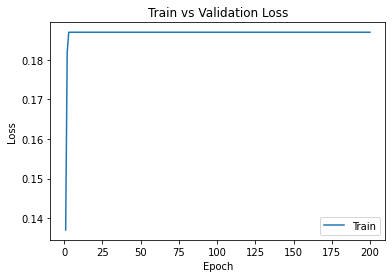

In [60]:
#ratio_net = RatioNet(input_size=len(tokenised_data.vocab), batch_size=10)
ratio_net = no_lstm_RatioNet(input_size=len(tokenised_data.vocab), batch_size=10, device=device, embedding_size=50,num_layers=1, hidden_size=50, lstm_input_size=50)

train_net(ratio_net, sanity_loader, device=device, sanity_check=True, epochs=200 , learning_rate=0.01, adam=False)
model_path = path(ratio_net.name, 10, 0.01, 199)

print(model_path)
plot_training_curve(model_path)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, Train Loss: 0.1654263898730278, Validation Loss: [not yet available], prediction: 0.048810433596372604, true ratio: 0.042500000447034836
Epoch: 1, Train Loss: 0.16588093526661396, Validation Loss: [not yet available], prediction: 0.04880716651678085, true ratio: 0.1898999959230423
Epoch: 2, Train Loss: 0.16524195219390095, Validation Loss: [not yet available], prediction: 0.048811543732881546, true ratio: 0.2962000072002411
Epoch: 3, Train Loss: 0.16549607971683145, Validation Loss: [not yet available], prediction: 0.0487922765314579, true ratio: 0.2962000072002411
Epoch: 4, Train Loss: 0.16590033723041414, Validation Loss: [not yet available], prediction: 0.04880519583821297, true ratio: 0.08799999952316284
Epoch: 5, Train Loss: 0.16522890720516442, Validation Loss: [not yet available], prediction: 0.04881567135453224, true ratio: 0.0820000022649765
Epoch: 6, Train Loss: 0.1659528873860836, Validation Loss: [not yet available], prediction: 0.048813652247190475, true ratio: 0

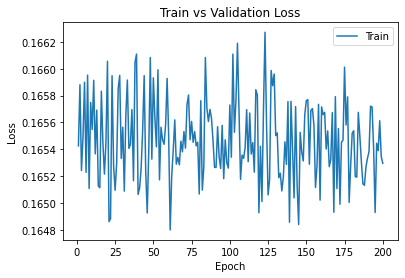

In [63]:
#ratio_net = RatioNet(input_size=len(tokenised_data.vocab), batch_size=10)
ratio_net = RatioNet2(input_size=len(tokenised_data.vocab), batch_size=10, device=device, embedding_size=50,num_layers=1, hidden_size=50, lstm_input_size=50)

train_net(ratio_net, sanity_loader, device=device, sanity_check=True, epochs=200 , learning_rate=0.000000001, adam=True, weight_decay=0)
model_path = path(ratio_net.name, 10, 0.000000001, 199)

print(model_path)
plot_training_curve(model_path)


In [32]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
